__Cuaderno de trabajo de:__ Nombre Apellido

# Regresión no lineal

Concluimos el capítulo 3 del libro ["Introduction to Statistical Learning"](http://www-bcf.usc.edu/~gareth/ISL/).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns

from sklearn.preprocessing import scale, PolynomialFeatures
import sklearn.linear_model as skl_lm
import sklearn.metrics
import statsmodels.api as sm
import statsmodels.formula.api as smf
%matplotlib inline

plt.style.use('seaborn-white')

## Cargamos los datos

Cargamos los conjuntos de datos que vamos a usar

Los conjuntos de datos están en la web del libro (pero ya están descargados)
http://www-bcf.usc.edu/~gareth/ISL/data.html

In [2]:
advertising = pd.read_csv('advertising.csv', usecols=[1,2,3,4])
advertising.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   Radio      200 non-null    float64
 2   Newspaper  200 non-null    float64
 3   Sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


## Regresión y ajuste de modelos


El análisis de regresión consiste en encontrar un  **modelo** que relaciona los valores medidos de una variable **objetivo** (tb se llama la **respuesta**) en función de un conjunto de variables **explicativas** (tb **variables predictoras**, o **regresores**).

Los valores medidos en el mundo real nunca se ajustan de forma perfecta a un modelo, debido en primer lugar a errores de medida, pero también a que cualquier modelo matemático es una *simplificación* del mundo real, y si tuviera en cuenta todos los factores que influyen en un conjunto de variables, sería inmanejable.

Por tanto, no tiene sentido aspirar a encontrar un modelo que prediga exactamente los valores medidos, y debemos admitir que el modelo cometerá un cierto error.

Un modelo útil encuentra una relación funcional sencilla en conjuntos de pocas variables. Se trata de explicar una variable objetivo en función de otro conjunto de variables mejor conocidas o más fáciles de medir. El  **análisis de regresión**  (más exactamente, el análisis de regresión  *paramétrico*) permite encontrar un modelo explicativo en dos etapas:


 1. Nuestro conocimiento del tema en cuestión nos permite escribir un modelo que afirma que la variable  *Y*  es una función de las variables $X_1,\dots,X_p$. La variable  *Y* se suele llamar la **respuesta** y las variables  $X_1,\dots,X_p$ se llaman  **variables predictoras**. La forma exacta de la función no está fijada a priori, sino que depende de unos pocos  **parámetros**  libres.
 
 Por ejemplo, para la **regresión lineal**, el modelo es
 $$
 Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \dots + \beta_p X_p + \epsilon
 $$
 donde $\beta_0,\dots,\beta_p$ son los parámetros y $\epsilon$ es un error que no podemos explicar dentro de este modelo.
 
 2. **Ajustamos el modelo** a los datos de que disponemos, eligiendo los valores de los parámetros para los que la distancia entre los valores medidos de la variable  *Y*  y los valores predichos aplicando el modelo minimizan el error cometido. El error que se suele minimizar es el error cuadrático (**residual sum of squares**):
$$
RSS = e_1^2 + e_2^2 + \dots + e_n^2
$$
donde
$$
e_1 = y_1 - (\beta_0 + \beta_1 x_1), \dots e_n = y_n - (\beta_0 + \beta_1 x_n).
$$
Es decir, entre todos los posibles coeficientes $\beta_0,\dots,\beta_p$ nos quedamos con aquellos $\hat{\beta_0},\hat{\beta_1},\dots,\hat{\beta_1}$ que minimizan el RSS, y hemos obtenido la  **regresión lineal por mínimos cuadrados** (**least squares**).

### Ejemplo de ventas y anuncios

Recordamos el modelo lineal

$$
Sales\approx \beta_0 + \beta_1\times TV  + \beta_2\times radio  + \varepsilon
$$

de la sesión anterior.

In [3]:
regr = skl_lm.LinearRegression()

X = advertising[['Radio', 'TV']]
y = advertising[['Sales']]

regr.fit(X,y)
print(regr.score(X,y))

0.8971942610828956


### Dibujar el modelo

El número $R^2$ es útil para decidir si el modelo ajusta correctamente, pero puede ser incluso más útil (si es posible) dibujar los datos junto con el ajuste para buscar un patrón. Si observamos dónde falla el modelo, podemos pensar cómo mejorarlo.

Por ejemplo, dibujamos la gráfica del ajuste lineal junto con los puntos.

In [4]:
est = smf.ols('Sales ~ TV + Radio', advertising).fit()

adv = advertising.copy()
#Añadimos una columna con los residuos (con signo)
adv['res'] = est.resid
adv.describe()

,TV,Radio,Newspaper,Sales,res
count,200.000000,200.000000,200.000000,200.000000,2.000000e+02
mean,147.042500,23.264000,30.554000,14.022500,6.137313e-15
std,85.854236,14.846809,21.778621,5.217457,1.672891e+00
min,0.700000,0.000000,0.300000,1.600000,-8.797700e+00
25%,74.375000,9.975000,12.750000,10.375000,-8.751582e-01
50%,149.750000,22.900000,25.750000,12.900000,2.421943e-01
75%,218.825000,36.525000,45.100000,17.400000,1.170770e+00
max,296.400000,49.600000,114.000000,27.000000,2.832837e+00


In [5]:
est.params

Intercept    2.921100
TV           0.045755
Radio        0.187994
dtype: float64

In [6]:
# What are the min/max values of Radio & TV?
# Use these values to set up the grid for plotting.
advertising[['Radio', 'TV']].describe()

,Radio,TV
count,200.000000,200.000000
mean,23.264000,147.042500
std,14.846809,85.854236
min,0.000000,0.700000
25%,9.975000,74.375000
50%,22.900000,149.750000
75%,36.525000,218.825000
max,49.600000,296.400000


In [7]:
# Create a coordinate grid
Radio = np.arange(0,50)
TV = np.arange(0,300)

B1, B2 = np.meshgrid(Radio, TV, indexing='xy')
Z = np.zeros((TV.size, Radio.size))

intercept, beta_TV, beta_RADIO = est.params
for (i,j),v in np.ndenumerate(Z):
        Z[i,j] =(intercept + B1[i,j]*beta_RADIO + B2[i,j]*beta_TV)

In [8]:
%matplotlib inline

<ipython-input-9-a884988af05b>:5: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = axes3d.Axes3D(fig)


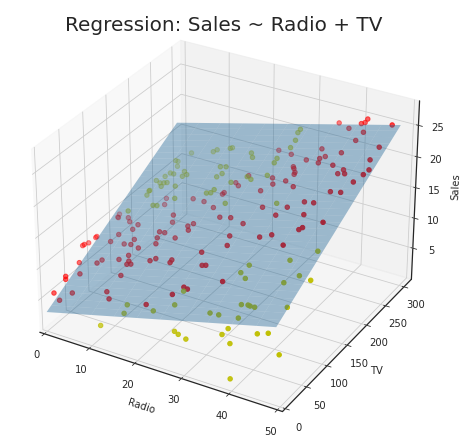

In [9]:
# Create plot
fig = plt.figure(figsize=(6,6))
fig.suptitle('Regression: Sales ~ Radio + TV', fontsize=20)

ax = axes3d.Axes3D(fig)

ax.plot_surface(B1, B2, Z, rstride=10, cstride=5, alpha=0.4)
adv_plus = adv[adv.res>0]
adv_minus = adv[adv.res<=0]
ax.scatter3D(adv_plus.Radio, adv_plus.TV, adv_plus.Sales, c='r')
ax.scatter3D(adv_minus.Radio, adv_minus.TV, adv_minus.Sales, c='y')

ax.set_xlabel('Radio')
ax.set_xlim(0,50)
ax.set_ylabel('TV')
ax.set_ylim(bottom=0)
ax.set_zlabel('Sales');

Alternativamente, hacemos un dibujo 2d, donde las coordenadas (x,y) de un punto son los valores de inversión en TV y Radio, y el color es el residuo (el error cometido), con signo.

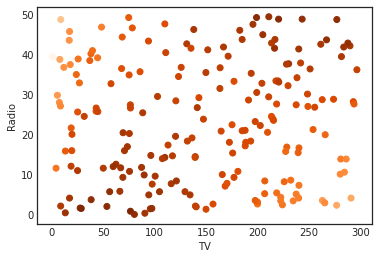

In [10]:
#non-interactive plot
%matplotlib inline 
#Color oscuro es un residuo negativo
#Color claro es un residuo positivo
plt.scatter(x=adv.TV, y=adv.Radio, c=adv.res, cmap='Oranges')
plt.xlabel('TV')
plt.ylabel('Radio')
plt.show()

El patrón es claro: 

> El modelo lineal estima las ventas a la baja cuando la inversión en TV y Radio siguen una relación lineal (que a ojo parece que es 5 veces más inversión en TV que en Radio), y estima las ventas al alza cuando la inversión es alta en TV pero baja en Radio, o viceversa.

Este patrón puede deberse a que hay una sinergia entre las inversiones en TV y Radio. Es decir: invertir en ambos medios es más eficaz que la suma de los efectos de cada inversión por separado.

### Variables de interacción

Podemos ajustar un modelo lineal, pero incluyendo nuevas columnas derivadas de los datos originales, que dependan de las columnas originales de forma no lineal.

Por ejemplo, podemos incluir un término de interacción entre las variables TV y Radio.

### Ajustar un modelo no lineal con statsmodels

Para ajustar un modelo no lineal con statsmodels es suficiente con modificar la fórmula:

> ``Sales ~ TV + Radio + TV*Radio``

Usa como columnas TV, Radio, y el producto de TV y Radio.

En este caso, para predecir, tenemos que pasar las columnas ``TV`` y ``Radio``
```python
df = pd.DataFrame({
    'TV':[100,200],
    'Radio':[20,30],
})
est.predict(df)
```


> ``resistence ~ np.log(speed)``

Regresión de la columna ``resistence`` como función del logaritmo de la columna ``speed``.

En este caso, para predecir, sólo tenemos que pasar la columna ``speed``
```python
df = pd.DataFrame({
    'speed':[21,22,23,24],
})
est.predict(df)
```

> ``Sales ~ TV + np.power(TV,2)``

Regresión del modelo cuadrático
$$
Sales =\beta_0 + \beta_1 TV + \beta_2 TV^2 + \varepsilon
$$

En este caso, para predecir, sólo tenemos que pasar la columna ``TV``:
```python
df = pd.DataFrame({
    'TV':[100,200]
})
est.predict(df)
```

### Comparación de modelos

Comparamos los modelos

$$
Sales =\beta_0 + \beta_1 TV + \beta_2 Radio
$$

y

$$
Sales =\beta_0 + \beta_1 TV + \beta_2 Radio + \beta_3 TV \cdot Radio
$$

In [11]:
est = smf.ols('Sales ~ TV + Radio + TV*Radio', advertising).fit()
est.summary().tables[0]

Dep. Variable:,Sales,R-squared:,0.968
Model:,OLS,Adj. R-squared:,0.967
Method:,Least Squares,F-statistic:,1963.
Date:,"Mon, 16 Aug 2021",Prob (F-statistic):,6.68e-146
Time:,06:40:54,Log-Likelihood:,-270.14
No. Observations:,200,AIC:,548.3
Df Residuals:,196,BIC:,561.5
Df Model:,3,,
Covariance Type:,nonrobust,,


Comprobamos que este modelo supera al modelo 'Sales ~ TV + Radio' en todas las métricas:

In [12]:
est = smf.ols('Sales ~ TV + Radio', advertising).fit()
est.summary().tables[0]

Dep. Variable:,Sales,R-squared:,0.897
Model:,OLS,Adj. R-squared:,0.896
Method:,Least Squares,F-statistic:,859.6
Date:,"Mon, 16 Aug 2021",Prob (F-statistic):,4.83e-98
Time:,06:40:54,Log-Likelihood:,-386.20
No. Observations:,200,AIC:,778.4
Df Residuals:,197,BIC:,788.3
Df Model:,2,,
Covariance Type:,nonrobust,,


## Modelos de mayor grado

Ajustamos un modelo lineal a la relación entre el consumo (mpg, miles per galon) y la potencia (horsepower) de vehículos en USA. El modelo lineal no parece capturar bien la relación:

$$
mpg \approx \beta_0 + \beta_1\times hp + \varepsilon
$$

In [13]:
# With Seaborn's regplot() you can easily plot higher order polynomials.
plt.scatter(auto.horsepower, auto.mpg, facecolors='r', edgecolors='k', alpha=0.6, s=20) 
sns.regplot(auto.horsepower, auto.mpg, ci=None, label='Linear', scatter=False)
plt.legend()
plt.ylim(5,55)
plt.xlim(40,240);

NameError: name 'auto' is not defined

Vemos que un modelo cuadrático ajusta mucho mejor.
$$
mpg \approx \beta_0 + \beta_1\times hp + \beta_1\times hp^2 + \varepsilon
$$

In [ ]:
# With Seaborn's regplot() you can easily plot higher order polynomials.
plt.scatter(auto.horsepower, auto.mpg, facecolors='r', edgecolors='k', alpha=0.6, s=20) 
sns.regplot(auto.horsepower, auto.mpg, ci=None, label='Linear', scatter=False)
sns.regplot(auto.horsepower, auto.mpg, ci=None, label='Degree 2', order=2, scatter=False)
plt.legend()
plt.ylim(5,55)
plt.xlim(40,240);

Sin embargo, aumentar el grado del polinomio hará que ajustemos demasiado bien el *"ruido"*. Este fenónemo se denomina **overfitting**.

- El modelo tiene un error bajo en nuestro conjunto de datos.
- Cuando intentamos aplicar el modelo a una observación que no pertenece al conjunto original, la predicción es descabellada.

> *Si ajustamos un modelo con más coeficientes que observaciones, el ajuste será perfecto, pero el modelo es inútil.*

In [ ]:
# With Seaborn's regplot() you can easily plot higher order polynomials.
plt.scatter(auto.horsepower, auto.mpg, facecolors='r', edgecolors='k', alpha=0.6, s=20) 
sns.regplot(auto.horsepower, auto.mpg, ci=None, label='Linear', scatter=False)
sns.regplot(auto.horsepower, auto.mpg, ci=None, label='Degree 2', order=2, scatter=False)
sns.regplot(auto.horsepower, auto.mpg, ci=None, label='Degree 5', order=5, scatter=False)
plt.legend()
plt.ylim(5,55)
plt.xlim(40,240);

### Ajustar un modelo polinomial con scikit-learn

Para ajustar un modelo polinomial vamos a usar otra componente fundamental de ``scikit-learn``: el **preprocesado**, en este caso para conseguir las potencias de la columna ``horsepower``, usamos un objeto ``PolynomialFeatures``, que tiene un método ``fit_transform``, que aplicamos tanto al ajustar el modelo como al hacer predicciones:

```python
order=2
poly = PolynomialFeatures(order)
X = poly.fit_transform(auto[['horsepower']])
y = auto['mpg']

regr = skl_lm.LinearRegression()

regr.fit(X,y)

regr.predict(poly.fit_transform(250))
```

### Extrapolando con un modelo de orden alto

Probemos a usar los modelos polinomiales de distinto orden para predecir el valor de ``mpg`` para un coche de 250 HP de potencia.

In [ ]:
for order in [1,2,3,4,5]:
    poly = PolynomialFeatures(order)
    X = poly.fit_transform(auto[['horsepower']])
    y = auto['mpg']

    regr = skl_lm.LinearRegression()

    regr.fit(X,y)

    print('grado',order,':', regr.predict(poly.fit_transform([[250]])))

Misma info, pero de forma gráfica:

In [ ]:
x_new = 250

Lx = max(auto.horsepower) - min(auto.horsepower)
xmin, xmax = min(auto.horsepower) - Lx/10, max(auto.horsepower) + Lx/10
xmax = max(xmax, x_new+Lx/10)


X = auto[['horsepower']]
y = auto['mpg']

plt.figure(figsize=(8,8))
plt.scatter(auto.horsepower, auto.mpg, facecolors='r', edgecolors='k', alpha=0.6, s=20)
colors = 'rgbcmyk'
for order in range(1,6):
    poly = PolynomialFeatures(order)
    X = poly.fit_transform(auto[['horsepower']])

    regr = skl_lm.LinearRegression()

    regr.fit(X,y)

    regr.predict(poly.fit_transform([[250]]))

    #xs son puntos equiespaciados entre xmin y xmax
    xs = np.arange(xmin, xmax, Lx/100)
    #ys es el resultado de aplicar el modelo a cada punto de xs
    ys = regr.predict(poly.fit_transform(xs.reshape(-1,1)))
    #asi que plot(xs,ys) dibuja la grafica del modelo mpg = f(hp)
    plt.plot(xs, ys, 
             label='order %d'%order, 
             color=colors[order%(len(colors))])
    #Resaltamos la prediccion para hp=250
    plt.scatter([x_new], regr.predict(poly.fit_transform([[x_new]])), 
                facecolors=colors[order%(len(colors))],
                edgecolors='k', alpha=0.6, s=20)
    plt.legend()
#plt.ylim(ymin,ymax)
plt.xlim(xmin,xmax);

### regplot con bandas de confianza

Hemos visto que los resultados al extrapolar dependen fuertemente del modelo escogido. Sin embargo, si usamos modelos de distinto orden para predecir el valor de ``mpg`` de un coche cuya potencia está dentro del rango de nuestro conjunto de datos los resultados no varían tanto.

Otra forma de saber si nos podemos fiar del modelo es pedir a ``regplot`` que dibuje bandas de error alrededor del modelo que ha ajustado. Estas bandas se obtienen mediante el método de **bootstrap**, que en vez de ajustar un modelo ajusta muchos, a distintos subconjuntos de los datos, y comprueba si todos esos modelos arrojan predicciones similares o dispares.

No le daremos más vuelo a esta idea. Si a alguien le interesa, que pida más referencias (puede leer el capítulo 5.2 del [Introduction to Statistical Learning](https://www.clinicadentalordonez.com/clinicas.php)):

In [ ]:
for order in [1,2,3,4,6]:
    plt.scatter(auto.horsepower, auto.mpg, facecolors='r', edgecolors='k', alpha=0.6, s=20) 
    sns.regplot(auto.horsepower, auto.mpg, ci=95, label='Degree %d'%order, order=order, scatter=False)
    plt.legend()
    plt.ylim(5,55)
    plt.xlim(40,240);
    plt.show()

> Observamos que las bandas de error se mantienen bajo control dentro del rango de los datos, pero se disparan cuando usamos el modelo para extrapolar.

## Conjuntos "train" y "test"

Vamos a hacer este análisis de forma un poco más sistemática, introduciendo además un concepto nuevo: los conjuntos de **entrenamiento (train set)** y **evaluación (test set)**:

 - **train set**: Se usa para ajustar el modelo.
 - **test set**: *No* se usa para ajustar el modelo, sino *únicamente* para comprobar el error que comete el modelo ajustado en el conjunto *train*.

> *¿Cómo los obtenemos?*

Antes de hacer el análisis, *dividimos nuestros datos en los dos conjuntos*:
 - Podemos asignar cada dato a ``train`` o a ``test`` **de forma aleatoria**.
 - Podemos asignar los datos a ``train`` o a ``test`` **siguiendo un criterio** concreto que tenga sentido. Por ejemplo, los datos hasta el 2017 son para train, y los datos de 2017 son para test. Puede tener sentido si vamos a usar el modelo para extrapolar.

In [ ]:
# La funcion train_test_split reparte un conjunto en dos partes
# train y test, de forma aleatoria
from sklearn.model_selection import train_test_split

X = auto[['horsepower']]
y = auto['mpg']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

 - Entrenamos el modelo *sólo con el conjunto de entrenamiento*.
 - Calculamos el error cuadrático medio que comete el modelo en los conjuntos de train y de test:


```python 
regr = skl_lm.LinearRegression()

regr.fit(X_train,y_train)

def error_cuadratico_medio(regr, x, y):
    return sum((regr.predict(x) - y)**2)/len(y)

print(error_cuadratico_medio(regr, X_train, y_train))
print(error_cuadratico_medio(regr, X_test, y_test))
```

No usamos el $R^2$, porque compara el error cuadrático medio de nuestro modelo con la varianza del conjunto ``y_test``, pero la varianza es el error cuadrático medio que comete el modelo "constante" igual a ``y_test.mean()``, (la media de ``y_test``), y no es una comparación justa, porque nuestro modelo no puede usar los datos de ``y_test``, sino únicamente los datos de ``y_train``.

In [ ]:
regr = skl_lm.LinearRegression()

regr.fit(X_train,y_train)

def error_cuadratico_medio(regr, x, y):
    return sum((regr.predict(x) - y)**2)/len(y)

print(error_cuadratico_medio(regr, X_train, y_train))
print(error_cuadratico_medio(regr, X_test, y_test))

Repetimos lo anterior para modelos de varios grados:

In [ ]:
from sklearn.model_selection import train_test_split

max_order = 15

X = auto[['horsepower']].values
y = auto['mpg']
for order in range(1,max_order):
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25)
    plt.scatter(X_train[:,0], y_train, 
                facecolors='r', edgecolors='k', alpha=0.6, s=20,
                label='train')
    plt.scatter(X_test[:,0], y_test,
                facecolors='g', edgecolors='k', alpha=0.6, s=20,
                label='test')
    sns.regplot(X_train[:,0], y_train, ci=None, label='Degree %d'%order, order=order, scatter=False)
    plt.legend()
    plt.show()

Medimos esta información de forma numérica, pero en vez de quedarnos con una descomposición (train, test), repetimos N veces y tomamos el promedio de los errores cuadráticos medios. Se puede mejorar, pero nos da una idea:

In [ ]:
from sklearn.model_selection import train_test_split

#
N = 40
max_order = 20

y = auto['mpg']

for order in range(1,max_order):
    poly = PolynomialFeatures(order)
    X = poly.fit_transform( auto[['horsepower']])
    sum_scores = 0
    sum_scores2 = 0
    for _ in range(N):
        X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.25)
        regr = skl_lm.LinearRegression()
        regr.fit(X_train,y_train)
        sum_scores += error_cuadratico_medio(regr, X_test, y_test)
    print(order,':',sum_scores/N)

Observamos que el modelo no aumenta su poder predictivo de forma significativa cuando aumentamos el orden del modelo por encima de 2, aunque el error no decae de forma severa hasta que no llegamos a orden 10, aproximadamente.

Sin embargo, si pensamos usar el modelo para extrapolar, es importante comprobar que el modelo funcione bien cuando extrapolamos, y para ello *no debemos elegir el conjunto de test al azar*.

Observemos qué ocurre si tomamos como conjunto de test los 40 vehículos de mayor potencia.

In [ ]:
auto = auto.sort_values(by='horsepower')

In [ ]:
max_order = 5
split_index = len(auto) - 40

X = auto[['horsepower']].values
y = auto['mpg']

#xs son puntos equiespaciados entre xmin y xmax
xs = np.arange(xmin, xmax, Lx/100)

for order in range(1,max_order):
    X_train, X_test = X[:split_index,:], X[split_index:,:]
    y_train, y_test = y[:split_index], y[split_index:]
    
    poly = PolynomialFeatures(order)
    Xpower = poly.fit_transform(X_train)

    regr = skl_lm.LinearRegression()

    regr.fit(Xpower, y_train)

    #ys es el resultado de aplicar el modelo a cada punto de xs
    ys = regr.predict(poly.fit_transform(xs.reshape(-1,1)))
    #asi que plot(xs,ys) dibuja la grafica del modelo mpg = f(hp)
    plt.plot(xs, ys, label='order %d'%order)
    
    plt.scatter(X_train[:,0], y_train, 
                facecolors='r', edgecolors='k', alpha=0.6, s=20,
                label='train')
    plt.scatter(X_test[:,0], y_test,
                facecolors='g', edgecolors='k', alpha=0.6, s=20,
                label='test')
    plt.legend()
    plt.show()

Calculamos el error cuando entrenamos con los 352 primeros vehículos e intentamos predecir el mpg de los 40 vehículos de mayor potencia.

In [ ]:
max_order = 10
split_index = len(auto) - 40

y = auto['mpg']

for order in range(1,max_order):
    poly = PolynomialFeatures(order)
    X = poly.fit_transform( auto[['horsepower']])
    X_train, X_test = X[:split_index,:], X[split_index:,:]
    y_train, y_test = y[:split_index], y[split_index:]
    regr = skl_lm.LinearRegression()
    regr.fit(X_train,y_train)
    print(order,':',error_cuadratico_medio(regr, X_test, y_test))

La predicción mejora al pasar de un modelo de orden 1 a un modelo de orden 2, pero empeora si seguimos aumentado el orden del modelo.

> _Extrapolar es mucho más difícil que interpolar_

### Ejercicio 1

 - Carga el conjunto ``seaice.csv``, sobre la extensión del hielo polar.
 - Selecciona sólo los datos de extensión del hielo en el hemisferio norte.
 - Intenta explicar los datos de extensión del hielo polar en función del año y el mes, tomando el mes como variable categórica.
 - Añade a lo anterior el año al cuadrado como variable explicativa, para tener un modelo cuadrático del año, y manteniendo el mes como variable categórica. ¿Qué signo tiene el coeficiente del término año al cuadrado? ¿Puedes interpretar el signo de este coeficiente como una indicación de que la pérdida de hielo en el ártico se está acelerando o se está frenando?
 - Usa el modelo cuadrático para extrapolar la extensión del hielo en el Oceáno Ártico en Agosto de 2030, 2040 y 2050. Compara el resultado con los obtenidos para el modelo lineal.

**Sugerencia**: Usa statsmodel y `... + C(nombre_variable) + ...` para convertir una variable entera en categórica, como hiciste la semana pasada.

In [ ]:
ice = pd.read_csv('seaice.csv')
ice.head()

### Ejercicio 2

 - Sobre el mismo dataset ``seaice.csv``.
 - Selecciona sólo los datos de extensión del hielo en el hemisferio norte y sólo los datos de los meses de Agosto.
 - Ajusta modelos polinomiales que expliquen la extensión del hielo Ártico en Agosto, en función del año, pero de distintos órdenes.
 - Divide los datos en conjuntos ``train`` y ``test``, de modo que ``train`` contenga entradas hasta una cierta fecha (2005, por ejemplo), y ``test`` contenga el resto. Decide cuál es el orden para el que el modelo extrapola mejor.

### Ejercicio 3

 - Carga el conjunto ``yacht_hydrodynamics.csv``, sobre características hidrodinámicas de ciertos cascos de yate medidas en canal de ensayos.
 - Ajusta un modelo lineal para la resistencia, usando como única variable explicativa el número de Froude.
 - Ajusta un modelo polinómico para la resistencia, usando como única variable explicativa el número de Froude.
 - Compara de alguna manera los modelos anteriores.
 - Intenta hacer predicciones de resistencia para número de Froude 0.5 y 0.6: ¿tienen sentido esas predicciones?

In [ ]:
yacht = pd.read_csv('yacht_hydrodynamics.csv')

In [ ]:
yacht.head()

## Glosario en inglés

- **regresión**: *regression*
- **sobreajuste**: *overfitting*
- **conjunto de entrenamiento**: *train set*
- **conjunto de evaluación**: *test set*
- **ajustar un modelo**: *fit a model*
- **hacer predicciones**: *make predictions*
